# Title

## Business Overview

### The problem

We were tasked with providing Computing Vision a series of suggestions for their transition into the film industry. Specifically, we aimed to determine suggestions that could target higher levels of revenue and/or profit.

### The goal

The film industry is a creative and diverse market with several avenues to success. With the understanding that there is no one path to success, we aimed to generate insight into a variety of actions Computing Vision may want to take in order to carve their own unique path to success. To accomplish this goal, we analyzed several different facets of films and their relation to generating revenue and profit. These areas included genres, day of release, and experience level of directors. 

## The Datasets

The range of our analyses required utilization of several datasets. For each area of analysis, we used:

Directors:

Release Day:

Genres:
- Movie Budgets dataset from (INSERT SOURCE HERE). Including movie titles, production budget, and worldwide gross revenue. 
- TMDB dataset including movie titles and genres.

## The Methods and Results

##  DIMA
### Experience Level of Directors as a Predictor of Profit

***The Business Question***

Does the expertise of the director affect the movie's profitability?

**The Datasets**

In this section, we used the following datasets:
- Movie Info dataset from Rotten Tomatoes which included the Director column required for this analysis.
- Movie Budgets dataset from The-Numbers which included the movie titles, production budget, and worlwide gross which we used to calculate the profit which is our main measure of success in the project

Before starting to explore the data we will first start off with importing the necessary libraries needed.

In [2]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris
from pandas import Series, DataFrame

%matplotlib inline

### Movie Info
Starting with the movie info dataframe, the first step is to read into the tsv file

In [4]:
# Read in the data as movie_info
# Use parse_dates and pass column name to read it as a datetime
movie_info = pd.read_csv('../Data/rt.movie_info.tsv', encoding='latin-1', sep='\t', 
                        parse_dates=['theater_date', 'dvd_date'])
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaT,NaN,NaN,200 minutes,NaN


In [6]:
#displaying the columns
movie_info.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [7]:
# Info on the dataframe
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    object        
 10  runtime       1530 non-null   object        
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 146.4+ KB


#### Data Cleaning
In this section, we will start by cleaning the movie_info dataframe before we can draw any conclusions. It will help us inspect the data better and get a more accurate general understanding of the data at hand.

Step 1: Check if we have any null values in each column

In [9]:
movie_info.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

Step 2: Dealing with null values

To clean the columns from null values, I will be replacing the values in some of the columns with 'Missing" so that it's all consistent across the columns

In [10]:
#Fill the missing values in synposis, genre, director, writer, currency, studio with 'Missing'
movie_info['synopsis'].fillna('Missing', inplace=True)
movie_info['rating'].fillna('Missing', inplace=True)
movie_info['genre'].fillna('Missing', inplace=True)
movie_info['director'].fillna('Missing', inplace=True)
movie_info['writer'].fillna('Missing', inplace=True)
movie_info['currency'].fillna('Missing', inplace=True)
movie_info['studio'].fillna('Missing', inplace=True)

In [11]:
#Fill theater_date and dvd_date missing values with a generic date "1800-01-01" to keep same format
movie_info['theater_date'].fillna('1800-01-01', inplace=True)
movie_info['dvd_date'].fillna('1800-01-01', inplace=True)

In [12]:
#Fill box_office missing valus with 0
movie_info['box_office'].fillna(0, inplace=True)

In [13]:
#Fill runtime missing valus with 0
movie_info['runtime'].fillna('0 minutes', inplace=True)

Step 3: check for any duplicates

In [14]:
movie_info.duplicated().value_counts()

False    1560
dtype: int64

It doesn't look like we have any duplicates. In this case, we are good to proceed forward.

Step 4: Change the type of data so that we are able to use it later on if we needed to.

In [15]:
movie_info['runtime'] = movie_info['runtime'].str.replace('minutes',"")
movie_info['runtime'] = pd.to_numeric(movie_info['runtime'])

#### Analysis methods

In this section, We will look into the Director column within this data frame to see if the Director's expertise affects the movie's success.

The question being analyzed is whether the expertise of the director affects the movie's profitability?

We will look at the count of movies directed per director, as directors with more experience could potentially yield higher profit due to their expertise.

- First, we want to sort directors by the amount of movies they've directed.
- Second, we want to look at the trend between the count of movies per director and the profit
    - To do that, we will merge the budget dataframe and movie_info dataframe to check the profit generated by each director.
- Third, we will sort the top directors with the highest average profit.

Step 1: sorting directors by the count of movies

In [17]:
movie_info['director'].value_counts()

Missing             199
Steven Spielberg     10
Clint Eastwood        8
William Beaudine      4
Jim Jarmusch          4
                   ... 
Stanley Donen         1
Jackie Kong           1
Simon Hunter          1
Roman Coppola         1
Larry Peerce          1
Name: director, Length: 1126, dtype: int64

In [18]:
# I will create a new dataframe so that I don't alter the original one
director_count = movie_info['director'].value_counts()
director_count

Missing             199
Steven Spielberg     10
Clint Eastwood        8
William Beaudine      4
Jim Jarmusch          4
                   ... 
Stanley Donen         1
Jackie Kong           1
Simon Hunter          1
Roman Coppola         1
Larry Peerce          1
Name: director, Length: 1126, dtype: int64

In [19]:
# I want to view the top 25 directors by count of movies directed
director_count.sort_values(ascending=False)[:26]

Missing                199
Steven Spielberg        10
Clint Eastwood           8
Bruce Beresford          4
Curtis Hanson            4
Alfred Hitchcock         4
Ridley Scott             4
William Friedkin         4
Barry Levinson           4
Yimou Zhang              4
Jim Jarmusch             4
William Beaudine         4
Woody Allen              4
Peter Bogdanovich        3
Hong Sang-soo            3
George Cukor             3
John Frankenheimer       3
Joseph Ruben             3
Howard Hawks             3
Fritz Lang               3
Boris Sagal              3
Charles Walters          3
George Sidney            3
Neil Jordan              3
John Landis              3
Phil Alden Robinson      3
Name: director, dtype: int64

In [52]:
# I will make a data frame with just the top 20 directors
top_director = movie_info['director'].value_counts().sort_values(ascending=False).head(26)
top_director

Missing                199
Steven Spielberg        10
Clint Eastwood           8
Bruce Beresford          4
Curtis Hanson            4
Alfred Hitchcock         4
Ridley Scott             4
William Friedkin         4
Barry Levinson           4
Yimou Zhang              4
Jim Jarmusch             4
William Beaudine         4
Woody Allen              4
Peter Bogdanovich        3
Hong Sang-soo            3
George Cukor             3
John Frankenheimer       3
Joseph Ruben             3
Howard Hawks             3
Fritz Lang               3
Boris Sagal              3
Charles Walters          3
George Sidney            3
Neil Jordan              3
John Landis              3
Phil Alden Robinson      3
Name: director, dtype: int64

In [53]:
#Previously I filled all the null values with Missing, I will go ahead and drop the missing row since I have no use for it.
top_director = top_director.drop(labels="Missing")

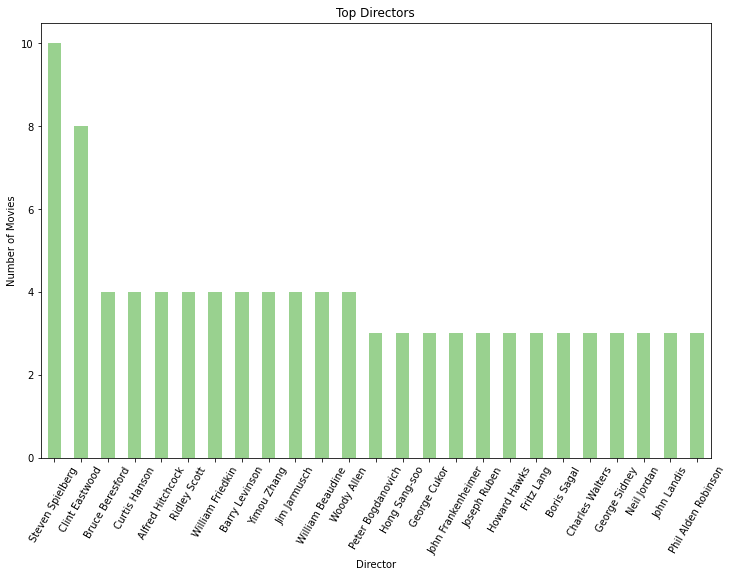

In [54]:
#Let's visualize the top 20 directors
ax = top_director.plot.bar(color='#99d18f', figsize=(12,8))
ax.tick_params(axis='x', labelrotation = 60)
ax.set_title('Top Directors')
ax.set_xlabel('Director')
ax.set_ylabel('Number of Movies');  

Step 2: Reading into the Budget Dataframe

Now that we've looked at top directors. We will look at directors in relation with profit and check if it has a direct relationship with the amount of profit.

For this, We will be using Morgan's work on the budget table since we need the profit and we'll continue from there.

In [24]:
#reading into the csv data file
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In this table we will assume that **Revenue** = 'worldwide_gross' & **Cost** = 'production_budget'

In [25]:
#will follow Morgan's data cleaning for this table
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")

# casting the values as integers
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

In [26]:
# removing $ and , from production budget
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])

In [27]:
# calculating total profit = revenue - cost
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

# confirmation
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747


From here on we will be comparing the total profit from the budgets table to the Directors in the movie_info table

In [29]:
# I don't really need all the columns from this df, therefore I will create one with just the columns useful to my analysis
movie_budgets = budgets[['id','movie','worldwide_gross','total_profit']]
movie_budgets

,id,movie,worldwide_gross,total_profit
0,1,Avatar,2776345279,2351345279
1,2,Pirates of the Caribbean: On Stranger Tides,1045663875,635063875
2,3,Dark Phoenix,149762350,-200237650
3,4,Avengers: Age of Ultron,1403013963,1072413963
4,5,Star Wars Ep. VIII: The Last Jedi,1316721747,999721747
...,...,...,...,...
5777,78,Red 11,0,-7000
5778,79,Following,240495,234495
5779,80,Return to the Land of Wonders,1338,-3662
5780,81,A Plague So Pleasant,0,-1400


### Merging movie_info & budget dataframes

Now I want to look to see if there are any trends between the directors and profit

In [30]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1560 non-null   object
 2   rating        1560 non-null   object
 3   genre         1560 non-null   object
 4   director      1560 non-null   object
 5   writer        1560 non-null   object
 6   theater_date  1560 non-null   object
 7   dvd_date      1560 non-null   object
 8   currency      1560 non-null   object
 9   box_office    1560 non-null   object
 10  runtime       1560 non-null   int64 
 11  studio        1560 non-null   object
dtypes: int64(2), object(10)
memory usage: 146.4+ KB


In [31]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5782 non-null   int64 
 1   movie            5782 non-null   object
 2   worldwide_gross  5782 non-null   int64 
 3   total_profit     5782 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 180.8+ KB


We will join the dataframes using an **inner** join because it returns only the records with matching keys in both tables, we will make a separate dataframe for the joined dataframes.

In [32]:
movie_info_budget = movie_budgets.join(movie_info, how='inner', lsuffix = '_movie_budgets' , rsuffix = '_movie_info')
movie_info_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 0 to 1559
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_movie_budgets  1560 non-null   int64 
 1   movie             1560 non-null   object
 2   worldwide_gross   1560 non-null   int64 
 3   total_profit      1560 non-null   int64 
 4   id_movie_info     1560 non-null   int64 
 5   synopsis          1560 non-null   object
 6   rating            1560 non-null   object
 7   genre             1560 non-null   object
 8   director          1560 non-null   object
 9   writer            1560 non-null   object
 10  theater_date      1560 non-null   object
 11  dvd_date          1560 non-null   object
 12  currency          1560 non-null   object
 13  box_office        1560 non-null   object
 14  runtime           1560 non-null   int64 
 15  studio            1560 non-null   object
dtypes: int64(5), object(11)
memory usage: 207.2+ KB


In [33]:
#checking the resulting dataframe
movie_info_budget.head()

,id_movie_budgets,movie,worldwide_gross,total_profit,id_movie_info,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,Avatar,2776345279,2351345279,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104,Missing
1,2,Pirates of the Caribbean: On Stranger Tides,1045663875,635063875,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108,Entertainment One
2,3,Dark Phoenix,149762350,-200237650,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13 00:00:00,2000-04-18 00:00:00,Missing,0,116,Missing
3,4,Avengers: Age of Ultron,1403013963,1072413963,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09 00:00:00,1997-08-27 00:00:00,Missing,0,128,Missing
4,5,Star Wars Ep. VIII: The Last Jedi,1316721747,999721747,7,Missing,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1800-01-01,1800-01-01,Missing,0,200,Missing


In [55]:
#I want to check how many 0 we have for worldwide gross to drop these value, we can see if the minimum number is 0
movie_info_budget['worldwide_gross'].describe()

count    1.560000e+03
mean     2.374879e+08
std      2.686596e+08
min      0.000000e+00
25%      6.806081e+07
50%      1.523167e+08
75%      3.029080e+08
max      2.776345e+09
Name: worldwide_gross, dtype: float64

In [57]:
#dropped 0 from worldwide in new data frame
movie_info_budget1 = movie_info_budget.loc[movie_info_budget['worldwide_gross'] > 0 ] 
movie_info_budget1['worldwide_gross'].describe()

count    1.545000e+03
mean     2.397936e+08
std      2.689348e+08
min      2.225400e+04
25%      6.979270e+07
50%      1.550112e+08
75%      3.052701e+08
max      2.776345e+09
Name: worldwide_gross, dtype: float64

I will look to see if there are trends between the count of movies per director vs. the total profit

In [36]:
#Create top directors df so that we can visualize top directors and top profit
director_counts = pd.DataFrame(movie_info_budget1.groupby('director')['movie'].count())
director_counts

,movie
director,
Abel Ferrara,2
Adam Ravetch|Sarah Robertson,1
Adam Shankman,1
Adam Silver|Ben Hayflick,1
Aditya Chopra,1
...,...
Youssef Delara,1
Yves Simoneau,1
Zak Penn,1


In [37]:
director_total_profit = pd.DataFrame(movie_info_budget1.groupby('director')['total_profit'].sum())
director_total_profit

,total_profit
director,
Abel Ferrara,236643115
Adam Ravetch|Sarah Robertson,72525156
Adam Shankman,225500000
Adam Silver|Ben Hayflick,122981799
Aditya Chopra,546865
...,...
Youssef Delara,-11019637
Yves Simoneau,109558505
Zak Penn,168700000


In [38]:
# I will now join the director counts and total profit together into a new df
top_directors = director_counts.join(director_total_profit, how='outer', lsuffix = '_director_counts' , rsuffix = 'director_total_profit')
top_directors

,movie,total_profit
director,,
Abel Ferrara,2,236643115
Adam Ravetch|Sarah Robertson,1,72525156
Adam Shankman,1,225500000
Adam Silver|Ben Hayflick,1,122981799
Aditya Chopra,1,546865
...,...,...
Youssef Delara,1,-11019637
Yves Simoneau,1,109558505
Zak Penn,1,168700000


In [39]:
top_directors = top_directors.sort_values(by='total_profit', ascending=False)
top_directors

,movie,total_profit
director,,
Missing,194,34814286971
William Friedkin,4,2705957834
Henning Schellerup,1,2008208395
Steven Spielberg,10,1777836004
Jake Kasdan,1,1748134200
...,...,...
Trish Sie,2,-89243731
Robert Hartford-Davis,1,-94635231
Renny Harlin,2,-111069937


In [40]:
#Dropping the missing values
top_directors = top_directors.drop(labels="Missing")

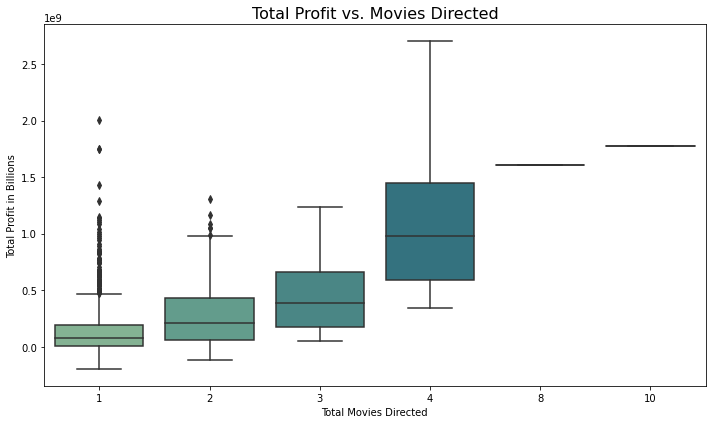

In [42]:
# Plot total profit vs. count of movies directed 
plt.figure(figsize=(10,6))
sns.boxplot(x = top_directors['movie'], y = top_directors['total_profit'], palette='crest')
plt.title('Total Profit vs. Movies Directed', fontsize=16)
plt.xlabel('Total Movies Directed')
plt.ylabel('Total Profit in Billions')
plt.tight_layout()
plt.show()

In [58]:
#Now I want to see it in terms of average profit instead of total profit
top_directors['avg_profit'] =  top_directors['total_profit']/top_directors['movie']
top_directors['avg_profit'].head()

director
William Friedkin      6.764895e+08
Henning Schellerup    2.008208e+09
Steven Spielberg      1.777836e+08
Jake Kasdan           1.748134e+09
Jay Russell           1.747311e+09
Name: avg_profit, dtype: float64

In [46]:
top_directors['avg_profit'] = top_directors['avg_profit'].sort_values(ascending=False)
top_directors

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Henning Schellerup,1,2008208395,2.008208e+09
Steven Spielberg,10,1777836004,1.777836e+08
Jake Kasdan,1,1748134200,1.748134e+09
Jay Russell,1,1747311220,1.747311e+09
...,...,...,...
Trish Sie,2,-89243731,-4.462187e+07
Robert Hartford-Davis,1,-94635231,-9.463523e+07
Renny Harlin,2,-111069937,-5.553497e+07


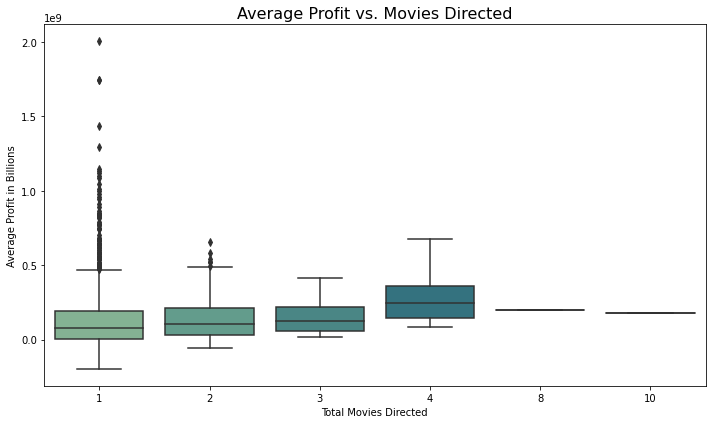

In [59]:
# Plot average profit vs. count of movies directed 
plt.figure(figsize=(10,6))
sns.boxplot(x = top_directors['movie'], y = top_directors['avg_profit'], palette='crest')
plt.title('Average Profit vs. Movies Directed', fontsize=16)
plt.xlabel('Total Movies Directed')
plt.ylabel('Average Profit in Billions')
plt.tight_layout()
plt.show()


The trend that both boxplots reflect is that directors that have directed 3 or more movies have always had an average profit that is positive. We can see that the minimum in the interquartile range is always positive for total movies directed of 3 or more.

Drawing from this trend, going forward we will look at the top 20 directors in terms of average profit that directed 3 or more movies.

In [49]:
#Getting the top 20 directors that directed 3 or more movies
three_plus_movies = top_directors[(top_directors['movie'] >= 3)].head(20)
three_plus_movies

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Steven Spielberg,10,1777836004,1.777836e+08
Clint Eastwood,8,1607570579,2.009463e+08
Woody Allen,4,1546517681,3.866294e+08
Yimou Zhang,4,1458132256,3.645331e+08
Barry Levinson,4,1435779099,3.589448e+08
Boris Sagal,3,1237332495,4.124442e+08
Jim Jarmusch,4,1050825592,2.627064e+08
Werner Herzog,3,911024954,3.036750e+08


In [50]:
three_plus_movies = three_plus_movies.reset_index()
three_plus_movies.head()

,director,movie,total_profit,avg_profit
0,William Friedkin,4,2705957834,6.764895e+08
1,Steven Spielberg,10,1777836004,1.777836e+08
2,Clint Eastwood,8,1607570579,2.009463e+08
3,Woody Allen,4,1546517681,3.866294e+08
4,Yimou Zhang,4,1458132256,3.645331e+08


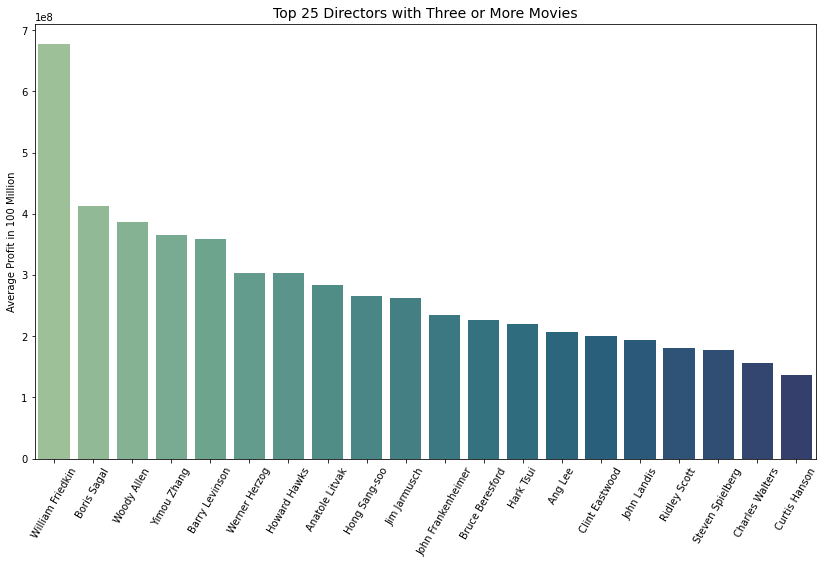

In [51]:
#now let's visualize the results
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x = three_plus_movies['director'], y = three_plus_movies['avg_profit'], order= three_plus_movies.sort_values('avg_profit',ascending = False).director, palette="crest")
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel('Average Profit in 100 Million')
plt.title('Top 25 Directors with Three or More Movies', fontsize=14)
plt.show();

This barplot portrays the top 20 directors in terms of average profit that have directed 3 or more movies. Drawing from this, if Computing Vision has the budget they could potentially hire one of these directors, or they can look into their work and get inspired by.

#### Conclusion / Suggestion

Our recommendation for Computing Vision is to hire experienced directors that have directed 3 or more movies. According to the previous analysis, experienced directors always resulted in positive average profit. Therefore, it is suggested that Computing Vision would work with experienced directors.


#### What limitations are there?

In the case of trying to recommend to hire one of the top 20 Directors in terms of their average profit and their expertise, a limitation was that some of the top 20 directors are in fact deceased. 
Deceased Directors: Boris Karloff, Howard Hawks, Anatole Litvak, John Frankenheimer, Charles Walters, Curtis Hanson. 

However, in light of this limitation, a business suggestion here would be to look into these directors' work and potentially acquiring the rights to their work if possible and generate profit off of that.

## LEO
### Day of Release as a Predictor of Revenue

#### Datasets and cleaning

#### Analysis methods

#### Conclusion / Suggestion

#### What limitations are there?

### Genre as a Predictor of Revenue (Chi Square Analysis)

#### The Business Question
Does the genre of a movie have any association with the movie's profitability?

#### The Datasets
- Movie Budgets dataset from (INSERT SOURCE HERE) including movie titles, production budget, and worldwide gross revenue. 
- TMDB dataset including movie titles and genres

#### The Methods

##### Import and Clean Data

We began with importing all relevant libraries for analysis and visualization. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

The relevant datasets for our analysis were the tn.movie_budgets.csv and tmdb.movies.csv files. 

In [2]:
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
tmdb = pd.read_csv("../data/tmdb.movies.csv", index_col = 0)

Before running our analysis, we needed to review the contents of the datasets, isolate relevant columns, and clean data as necessary.

First, we looked at the first few rows of the movie budgets dataframe in order to get an idea of the columns, potential datatypes, and areas which may require pre-processing and cleaning. 

In [3]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


From this dataframe, we decided that we needed to retain the following columns:
- Movie (for joining with other dataframes)
- Production Budget and Worldwide Gross (for calculating profit)

Thus, we formed a subset of the dataset including only the relevant columns.

In [4]:
cols_to_keep = ['movie','production_budget','worldwide_gross']
budgets_relevant = budgets[cols_to_keep]
budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"


We also noted that the production budget and worldwide gross columns were populated with strings (as evident by the symbolic characters used alongside the numeric characters, such as "$"). These values needed to be cleaned and cast as integers before they could be used to calculate profit. 

However, before doing any further cleaning we looked for null values and duplicates so that we could avoid making any unnecessary calculations

In [5]:
budgets_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie              5782 non-null   object
 1   production_budget  5782 non-null   object
 2   worldwide_gross    5782 non-null   object
dtypes: object(3)
memory usage: 135.6+ KB


Looking at the dataframe's information confirmed that the values within the production_budget and worldwide_gross columns were stored as strings and required cleaning. Furthermore, we could see that there were no obvious nulls in the dataframe. However, looking at the values stored within the worldwide_gross column brought to light some null-esque values. Namely, movies with a worldwide gross revenue of $0. 

In [6]:
budgets_relevant['worldwide_gross'].value_counts()

$0             367
$8,000,000       9
$2,000,000       6
$7,000,000       6
$4,000,000       4
              ... 
$14,942,422      1
$48,425,971      1
$6,100,000       1
$6,551,310       1
$76,904,429      1
Name: worldwide_gross, Length: 5356, dtype: int64

There were some zeroes in this column, presumably because there was no available data on its gross revenue. Rather than removing these observations, we decided to replace them with the median once the column had been properly cleaned. 

From here, we moved on to locating duplicate values. 

In [7]:
budgets_relevant.duplicated().value_counts()

False    5782
dtype: int64

There were no obvious duplicate rows. However, we realized that multiple movies could have the same title. This would pose an issue when we needed to join dataframes using movie titles as the mutual column. 

In [8]:
budgets_relevant['movie'].value_counts()

King Kong                             3
Halloween                             3
Home                                  3
Cinderella                            2
Twilight                              2
                                     ..
Blue Crush                            1
The Deep End                          1
Any Given Sunday                      1
Das Boot                              1
Terminator 3: Rise of the Machines    1
Name: movie, Length: 5698, dtype: int64

First, we looked into how many duplicate titles there were and if it was worth it to persue a method of merging the dataframes on two columns.

In [9]:
def get_title_counts(data, col):
    
    # set the value counts as a dataframe
    title_counts = pd.DataFrame(data[col].value_counts())
    
    # reset index so that we can easily access the titles
    title_counts = title_counts.reset_index()
    
    # take a subset of the title counts dataframe for all titles that appear more than once
    title_counts = title_counts.loc[ title_counts[col] > 1 ]
                                    
    # return this dataframe of title duplicates                                
    return title_counts

title_counts = get_title_counts(budgets_relevant, 'movie')
title_counts

,index,movie
0,King Kong,3
1,Halloween,3
2,Home,3
3,Cinderella,2
4,Twilight,2
...,...,...
76,Peteâs Dragon,2
77,Hamlet,2
78,Flatliners,2
79,Teenage Mutant Ninja Turtles,2


81 rows out of a 5,000+ row dataset didn't seem substantial enough to justify the attempted mutli-column merge given the time contraints of the project. So, we decided to simply drop the duplicates.

In [10]:
def remove_duplicate_titles(data, col):
    
    # get the dataframe for titles which appear more than once
    title_counts = get_title_counts(data,col)
    
    # create a dichotomous column for which there is a 1 if the movie is a duplicate title
    data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)
    
    # take a subset of the dataframe of only non-duplicate titles
    data = data.loc[ data['duplicate'] == 0]
    
    # initialize a list of columns to maintain
    keepers = []
    
    # for each column in the dataframe
    for col in data.columns:
        # if it isn't the duplicate column
        if col != "duplicate":
            # add it to the list of columns to be maintained
            keepers.append(col)
    
    # keep only the columns intended
    data = data[keepers]
        
    return data

budgets_relevant = remove_duplicate_titles(budgets_relevant, 'movie')
budgets_relevant

<ipython-input-10-de8f23511d27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)


,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"
...,...,...,...
5777,Red 11,"$7,000",$0
5778,Following,"$6,000","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338"
5780,A Plague So Pleasant,"$1,400",$0


After checking for nulls and duplicates, we got started cleaning the budget and gross revenue columns so that we could eventually use them to calculate profit. 

In [11]:
def dollar_to_numeric(column):
    # removing $ and , from string
    column = column.str.replace(",","")
    column = column.str.replace("$","")

    # casting the values as integers
    column = pd.to_numeric(column)
    
    return column

budgets_relevant['worldwide_gross'] = dollar_to_numeric(budgets_relevant['worldwide_gross'])
budgets_relevant['production_budget'] = dollar_to_numeric(budgets_relevant['production_budget'])

budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,425000000,2776345279
1,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875
2,Dark Phoenix,350000000,149762350
3,Avengers: Age of Ultron,330600000,1403013963
4,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747


After successfully casting the data as integers, we looked at the descriptive statistics for any obvious issues.

In [12]:
budgets_relevant['production_budget'].describe()

count    5.459000e+03
mean     3.112546e+07
std      4.134343e+07
min      1.100000e+03
25%      5.000000e+06
50%      1.700000e+07
75%      4.000000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

In [13]:
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     8.940551e+07
std      1.721636e+08
min      0.000000e+00
25%      3.808364e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

There are some zeroes in the worldwide gross revenue dataset. Since this most likely implies missing data, we looked to see how many rows this is the case for.

In [14]:
budgets_relevant['worldwide_gross'].value_counts()

0            355
8000000        7
7000000        6
2000000        6
4000000        4
            ... 
58545540       1
92618117       1
834953         1
190453132      1
310946         1
Name: worldwide_gross, Length: 5054, dtype: int64

Since this is a pretty substantial number of movies, but not a significant proportion of the dataset, we decided to impute these values with the median profit. The decision was made to use the median rather than the mean because of its resiliency against extreme outliers.

In [15]:
median_gross = budgets_relevant['worldwide_gross'].median()
budgets_relevant['worldwide_gross'] = budgets_relevant['worldwide_gross'].replace(0,median_gross)
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     9.116737e+07
std      1.713763e+08
min      2.600000e+01
25%      7.833752e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

Now that we had two clean revenue and cost columns to work with, we used this information to create a new column in the dataframe for the calculated profit. 

In [16]:
# calculating total profit
budgets_relevant['total_profit'] =  budgets_relevant['worldwide_gross'] - budgets_relevant['production_budget']

budgets_relevant = budgets_relevant[['movie','total_profit']]

# confirmation
budgets_relevant['total_profit'].describe()

count    5.459000e+03
mean     6.004190e+07
std      1.431806e+08
min     -2.002376e+08
25%     -1.394899e+06
50%      1.415149e+07
75%      5.964086e+07
max      2.351345e+09
Name: total_profit, dtype: float64

Next, we decided to visualize the distribution of profit since this is our dependent variable.

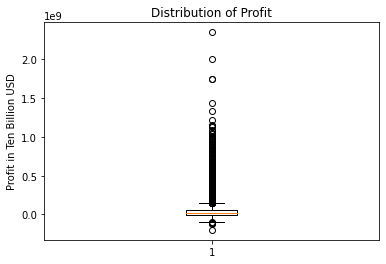

In [17]:
fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Ten Billion USD");

It was evident that there were some extremely profitable (and extremely unprofitable) movies that may influence the results of our analysis. Because of the presense of extremes, we decided to remove any movies with profits outside of the interquartile range.

Resource used: https://www.statology.org/remove-outliers-python/

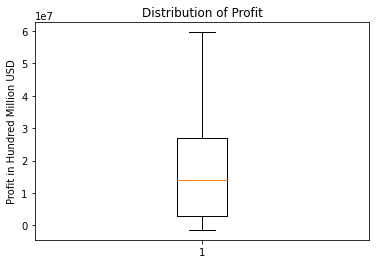

In [18]:
# find Q1, Q3, and interquartile range for each column
Q1 = budgets_relevant['total_profit'].quantile(q=.25)
Q3 = budgets_relevant['total_profit'].quantile(q=.75)
IQR = budgets_relevant['total_profit'].apply(stats.iqr)

budgets_relevant = budgets_relevant.loc[~((budgets_relevant['total_profit'] < (Q1-1.5*IQR)) | (budgets_relevant['total_profit'] > (Q3+1.5*IQR)))]

fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Hundred Million USD");

Knowing that we would eventually have to merge this dataframe with the TMDB dataframe, we also set the index to the column on which we wanted to merge (the movie title). 

In [19]:
budgets_relevant.set_index('movie', inplace = True)
budgets_relevant.head()

,total_profit
movie,
John Carter,7778100
Green Lantern,19535492
Jack the Giant Slayer,2687603
Hugo,47784
Valerian and the City of a Thousand Planets,35098356


With this dataframe cleaned, we moved on to the TMDB dataframe.

Just like the first dataframe, we began by looking at the first few rows to get an idea of the columns, datatypes, and areas which may require preprocessing/cleaning. 

In [20]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


From this dataframe, we noted that we only needed the following columns:
- Title (for merging)
- Genre_ids

We started with dropping the irrelevant columns.

In [21]:
cols_to_keep = ['title','genre_ids']
tmdb_relevant = tmdb[cols_to_keep]
tmdb_relevant.head()

,title,genre_ids
0,Harry Potter and the Deathly Hallows: Part 1,"[12, 14, 10751]"
1,How to Train Your Dragon,"[14, 12, 16, 10751]"
2,Iron Man 2,"[12, 28, 878]"
3,Toy Story,"[16, 35, 10751]"
4,Inception,"[28, 878, 12]"


We noted that the genre_ids column appeared to contain lists of multiple ids associated with specific genres. We needed to clean this column and replace these numbers with their associated genre. However, we decided to wait to replace these values until after the dummy columns were created because it would be easier to rename a small number of columns than replace multiple numbers in every cell with its associated genre. 

So for now, we moved on to locating null values and duplicates.

In [22]:
tmdb_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      26517 non-null  object
 1   genre_ids  26517 non-null  object
dtypes: object(2)
memory usage: 621.5+ KB


There didn't appear to be any null values in the dataset.

In [23]:
tmdb_relevant.duplicated().value_counts()

False    25429
True      1088
dtype: int64

There were, however, some duplicate movies which we needed to drop.

In [24]:
tmdb_relevant = tmdb_relevant.drop_duplicates()
tmdb_relevant.duplicated().value_counts()

False    25429
dtype: int64

There were also more duplicate titles to remove. We handled these the same as we did in the budgets dataframe. 

In [25]:
tmdb_relevant['title'].value_counts()

Home                       6
Lucky                      5
The Gift                   5
Aftermath                  5
Alone                      4
                          ..
The Livingston Gardener    1
Spit                       1
Blood Road                 1
Viva Amiga                 1
Shark Exorcist             1
Name: title, Length: 24688, dtype: int64

In [26]:
tmdb_relevant = remove_duplicate_titles(tmdb_relevant,'title')
tmdb_relevant['title'].value_counts()

Architects & Engineers: Solving the Mystery of WTC 7    1
Kanye West: 808s & Heartbreak at The Hollywood Bowl     1
Nocturne                                                1
Ali's Wedding                                           1
24 Hour Comic                                           1
                                                       ..
Mike and I                                              1
Around the Block                                        1
Door to Door                                            1
Beating Hearts                                          1
Entwinement                                             1
Name: title, Length: 17714, dtype: int64

After dropping these duplicate values, we set the movie titles as in the index in preparation for merging these two dataframes.

In [27]:
tmdb_relevant = tmdb_relevant.set_index('title')
tmdb_relevant

,genre_ids
title,
How to Train Your Dragon,"[14, 12, 16, 10751]"
Iron Man 2,"[12, 28, 878]"
Toy Story,"[16, 35, 10751]"
Inception,"[28, 878, 12]"
Percy Jackson & the Olympians: The Lightning Thief,"[12, 14, 10751]"
...,...
Laboratory Conditions,"[27, 18]"
_EXHIBIT_84xxx_,"[18, 53]"
The Last One,"[14, 28, 12]"


Now that we had cleaned the data, it was ready to be merged.

In [28]:
budgets_and_tmdb = budgets_relevant.join(tmdb_relevant, how='inner')
budgets_and_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, John Carter to Newlyweds
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_profit  656 non-null    int64 
 1   genre_ids     656 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


After merging the dataframes, we were left with a much smaller dataframe than either of the parent datasets. This, however, was expected given there was no gaurantee that the datasets would overlap in their contents significantly nor was there a gaurantee that there would not be any spelling errors in the titles that would prevent a successful join for at least some rows. Given the timeframe of this project, we decided to proceed with the knowledge that 656 movies can still provide some useful insights.

The genre_ids column is made up of strings. This means that we needed to remove any string characters and isolate each genre id before making dummy columns. We needed to accomplish the following:
1. Remove brackets and whitespace
2. Split by commas
3. Create a new dataframe with genres as columns and cells containing binary values, with 1 indicating a relevant genre for that movie. 

For this section, we utilized this resource to create our dummy columns: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

In [29]:
def create_dummy_cols(data, col):
    
    # remove [, ], and whitespace
    data[col] = data[col].str.strip("]")
    data[col] = data[col].str.strip("[")
    data[col] = data[col].str.replace(" ", "")
    
    # split genre ids by commas
    genre_ids = data[col].str.split(",")
    
    # create the binary dummy columns
    bin_genre_df = pd.get_dummies(genre_ids.apply(pd.Series).stack()).sum(level=0)
    budgets_and_genre_dummys = data.join(bin_genre_df, how='inner')
    
    # rename columns for genres
    budgets_and_genre_dummys.rename(columns = {'28' : 'Action', 
                                           '12' : 'Adventure',
                                          '16' : 'Animation',
                                          '35' : 'Comedy',
                                          '80' : 'Crime',
                                          '99' : 'Documentary',
                                          '18' : 'Drama',
                                          '10751' : 'Family',
                                          '14' : 'Fantasy',
                                          '36' : 'History',
                                          '27' : 'Horror',
                                          '10402' : 'Music',
                                          '9648' : 'Mystery',
                                          '10749' : 'Romance',
                                          '878' : 'SciFi',
                                          '10770' : 'TV',
                                          '53' : 'Thriller',
                                          '10752' : 'War',
                                          '37' : 'Western'}, inplace = True)
    return budgets_and_genre_dummys

budgets_and_genre_dummys = create_dummy_cols(budgets_and_tmdb,'genre_ids')
budgets_and_genre_dummys

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Horror,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exeter,464792,"53,27",0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Ten,27067880,"12,27,9648,53",0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
Dry Spell,27070880,"35,10749",0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
All Superheroes Must Die,27072880,"878,53",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Note: there is a dummy column seemingly associated with no genre. This appears to be the result of some titles which did not have any associated genre id. So, we dropped them from analysis. 

In [30]:
budgets_and_genre_dummys = budgets_and_genre_dummys.loc[ (budgets_and_genre_dummys[''] != 1) ] 

We decided to turn profit into a categorical variable denoting high vs. medium vs. low profit. The threshold values for these categories were decided as:

- High = 75th percentile and greater
- Medium = Greater than 25th percentile and lower than 75th percentile.
- Low = 25th percentile and lower

In [31]:
# define thresholds
iqr_Q1 = budgets_and_genre_dummys['total_profit'].quantile(q=.25)
iqr_Q3 = budgets_and_genre_dummys['total_profit'].quantile(q=.75)

# assign categories based on thresholds
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] >= iqr_Q3, 'relative_profit_cat'] = 'high'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] <= iqr_Q1, 'relative_profit_cat'] = 'low'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['relative_profit_cat'].isna() , 'relative_profit_cat'] = 'medium'

budgets_and_genre_dummys.head()

C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary,relative_profit_cat
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,medium
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,medium
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,low
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,low
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,high


##### Chi-Square Analysis

In preparation for chi-square analysis, nwe built a contingency table with genres as rows and relative profit category as columns.

In [32]:
# initialize list of genres
genres = []

# for each column in the dataset
for column in budgets_and_genre_dummys.columns:
    # if it isn't a non-genre column
    ignored_cols = ['total_profit','title','relative_profit_cat','genre_ids','']  
    if column not in ignored_cols:
        # add it to the list of genres
        genres.append(column)
        
## Creating the contingency table

# create a dataframe with profit as columns and genres as rows
contingency_table = pd.DataFrame(columns = ['high', 'medium','low'], index = genres)

# replace the index (this is useful for using the numeric index to populate the dataframe in the next cell)
contingency_table.reset_index(inplace = True)

# fill the table with zeroes
contingency_table = contingency_table.fillna(0)
contingency_table.head()

,index,high,medium,low
0,Music,0,0,0
1,Romance,0,0,0
2,Family,0,0,0
3,War,0,0,0
4,TV,0,0,0


After creating the contingency table, we iterated through each row in the original dataframe to populate the contingency table based on genre and profit category. 

Resource: https://www.geeksforgeeks.org/how-to-set-cell-value-in-pandas-dataframe/

In [33]:
# for each row
for index, row in budgets_and_genre_dummys.iterrows():
    
    # for each column in that row that is a genre
    for col in budgets_and_genre_dummys.columns:
        
        if col not in ignored_cols:
    
            # if the cell value is 1
            if row[col] == 1 :
                
                # find the index associated with that genre in the contingency table
                genre_idx = contingency_table[contingency_table['index'] == col].index.values
                
                # look at the profit category column and save that value as well
                profit_cat = row['relative_profit_cat']
    
                # find the cell associated with that row index and profit column in the contingency table and add 1 
                contingency_table.loc[genre_idx, profit_cat] += 1   
                
contingency_table

,index,high,medium,low
0,Music,1,6,5
1,Romance,27,47,28
2,Family,17,23,6
3,War,3,5,2
4,TV,0,3,1
5,Adventure,22,32,10
6,Fantasy,12,15,12
7,Animation,10,14,2
8,Drama,71,163,99
9,Horror,24,50,18


We noted that there were some genres where there weren't many movies. To avoid drawing conclusions based on small sample sizes, we decided to filter out rows in the contingency table with row totals less than 50. 

In [34]:
contingency_table = contingency_table.loc[contingency_table['high'] + contingency_table['medium'] + contingency_table['low'] >= 50]
contingency_table = contingency_table.set_index('index')
contingency_table

,high,medium,low
index,,,
Romance,27,47,28
Adventure,22,32,10
Drama,71,163,99
Horror,24,50,18
Action,36,69,14
Comedy,55,103,47
Thriller,45,101,41
Crime,30,38,19
SciFi,15,27,9


With the contingency table populated and filtered for decent sample size, we were ready to conduct the chi-squared test.

Resource: https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

In [35]:
from scipy.stats import chi2_contingency

# H_0 : Genre and Profit Level are not associated
# H_1: Genre and Profit Level are associated

stat, p, dof, expected = chi2_contingency(contingency_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.04456193254973362
Reject H_0


What this told us was that there was a significant association between these genres and relative profit categories. To dive deeper into the specifics, we needed to dichotomize our profit variable. 

We began with collapsing our medium and low profit categories into one category. This would allow us to see if there is a significant association between genres and higher profits. 

In [36]:
# Creating a copy of the contingency table
high_v_not_contingency = contingency_table.copy()

# Creating a new column to collapse the non-high profit categories into. 
high_v_not_contingency['not_high'] = high_v_not_contingency['medium'] + high_v_not_contingency['low']

# Isolating relevant columns
high_v_not_contingency = high_v_not_contingency[['high','not_high']]
high_v_not_contingency

,high,not_high
index,,
Romance,27,75
Adventure,22,42
Drama,71,262
Horror,24,68
Action,36,83
Comedy,55,150
Thriller,45,142
Crime,30,57
SciFi,15,36


From here, we conducted a new chi-square test to determine the presence of a significant association. 

In [37]:
stat, p, dof, expected = chi2_contingency(high_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.20704760836207542
Retain H_0


However, there was no significant association between genre and these profit categories. So, there doesn't appear to be a genre which generates significantly higher profit. However, there may be a genre that predicts significantly lower profit. 

To investigate this, we returned to our original contingency table and collapsed the 'high' and 'medium' columns into one column for non-low profit.

In [38]:
# Creating a copy of the original contingency table
low_v_not_contingency = contingency_table.copy()

# Collapsing high and medium profit categories into one column
low_v_not_contingency['not_low'] = low_v_not_contingency['high'] + low_v_not_contingency['medium']

# Isolating relevant columns
low_v_not_contingency = low_v_not_contingency[['low','not_low']]
low_v_not_contingency

,low,not_low
index,,
Romance,28,74
Adventure,10,54
Drama,99,234
Horror,18,74
Action,14,105
Comedy,47,158
Thriller,41,146
Crime,19,68
SciFi,9,42


We then conducted yet another Chi-Square test for significance. 

In [39]:
stat, p, dof, expected = chi2_contingency(low_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.009709037889535192
Reject H_0


The results were significant, meaning that there is a statistically significant association between genre and low profits. However, we do not know the strength of this association. To conceptualize the strength of their relationship, we calculated the Cramer's V value.

Resources used: 
- Cramer's V Methodology in Python: https://www.statology.org/cramers-v-in-python/#:~:text=Cramer%E2%80%99s%20V%20is%20a%20measure%20of%20the%20strength,Cramer%E2%80%99s%20V%20for%20a%20contingency%20table%20in%20Python.
- Interpreting Cramer's V value: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v
- Interpreting magnitude of Cramer's V: https://www.datascienceblog.net/post/statistical_test/effect_size/#:~:text=To%20interpret%20Cramer%E2%80%99s%20V%2C%20the%20following%20approach%20is,medium%20association%203%20V%20%3E%200.5%3A%20strong%20association

In [40]:
# Getting relevant values to calculate Cramer's V

# Sample size
n = low_v_not_contingency['low'].sum() + low_v_not_contingency['not_low'].sum()

# Number of rows
r = len(low_v_not_contingency)

# Number of columns
c = 2

cramer = np.sqrt((stat/n) / min(c-1,r-1))

print("Cramer's V: {}".format(round(cramer,2)))

Cramer's V: 0.13


The Cramer's V value ranges from 0 to 1. A result this small is indicative of a weak relationship between genre and low profit. 
So while our results remain statistically significant, the strength of their association is weak. 

Still we wondered, for which genres do we have greater proportions of profits above the 25th percentile?

To conceptualize this, we looked at the proportion of low profit vs. non-low profit within each genre. Then, we sorted our results such that the genre with the highest proportion of low profit movies appears highest on the dataframe. 

In [41]:
low_v_not_contingency['perc_low'] = round((low_v_not_contingency['low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency['perc_not_low'] = round((low_v_not_contingency['not_low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency = low_v_not_contingency[['perc_not_low','perc_low']]
low_v_not_contingency = low_v_not_contingency.sort_values(by = 'perc_low', ascending = False)
low_v_not_contingency

,perc_not_low,perc_low
index,,
Drama,70.27,29.73
Romance,72.55,27.45
Mystery,75.86,24.14
Comedy,77.07,22.93
Thriller,78.07,21.93
Crime,78.16,21.84
Horror,80.43,19.57
SciFi,82.35,17.65
Adventure,84.38,15.62


As a result, we can see that dramas have the greatest proportion of low-profit movies among our ten genre categories. This may be counterintuitive when paired with the knowledge that dramas were the genre that appeared most frequently within the dataframe.

#### Business Recommendation 

Our original business question asked: Does the genre of a movie have any association with the movie's profitability? From our analysis, we can now answer that the relationship between genre and profitability does appear to be significant in terms of reduced profitability. Specifically, there is a statistically significant association between genres and low profit within this sample of over 600 movies. However, this association is weak, meaning that there is no guarantee that choosing to produce a movie of a specific genre with lower proportions of low profit will absolutely prevent the movie's profit from falling below the 25th percentile. Thus, our business recommendation is as follows:

Our analyses suggest that action, adventure, and science fiction films tend to have lower proportions of movies whose profits fall under the 25th percentile. This suggests that it may be worthwhile for a company entering the film market to use this knowledge to guide further investigation into these genres as potential starting avenues for future work. If at all possible, we suggest further investigation into potential confounding factors that may better explain this significant difference, such as notable directors, production companies, actors, or themes. We suggest that this be taken as a loose guideline for furthur investigation based on the strength of this association. Trends are powerful, but not absolute. 


#### Limitations

Our results do not come without limitations. For example, while we did our best to ensure that the two tables were joined accurately, there exists the possibility that there exists a movie on one dataset with a title shared by an entirely different movie on the other dataset. However, with the timeframe provided for this project we have yet to explore this avenue. 

There is also the limitation of a relatively small sample size given the original sizes of our raw data. Unfortunately, a lot of movies had to be removed from the dataset during cleaning in order to optimize the accuracy of our output. However, similar studies with larger sample sizes would be beneficial in confirming the results of this analysis. 

Finally, there is the limitation of the strength of our results. Our small Cramer's V value implies that the association between genre and low profitability, while statistically significant, are weak at best. This is why our suggestion implies using these results as a general guideline to provide direction rather than concrete steps for action. 

#### Relevant Visualizations for the Final Ten Genres

1. Boxplot of Profit Distributions by Genre for Final Dataset

The boxplots below visualize the distributions of profits for the ten genres that were included in the final analysis.

Resources used included:
- https://stackoverflow.com/questions/70927004/plotting-several-boxplots-from-different-dataframes-in-one-graph
- https://www.geeksforgeeks.org/how-to-set-a-seaborn-chart-figure-size/#:~:text=To%20adjust%20the%20figure%20size%20of%20the%20seaborn,returns%20the%20figure%20and%20the%20array%20of%20axes.

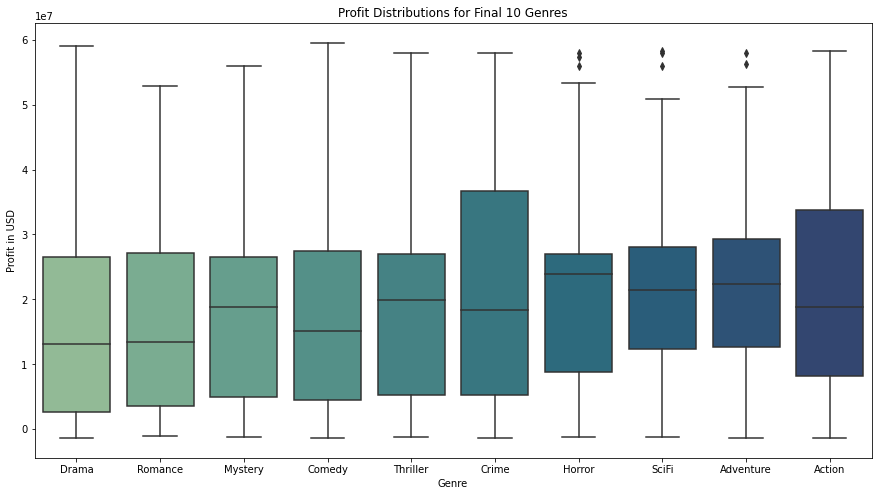

In [42]:
# Creating separate dataframes for each genre
romances = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Romance'] == 1)] 
adventures = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Adventure'] == 1)]
dramas = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Drama'] == 1)]
horrors = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Horror'] == 1)]
actions = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Action'] == 1)]
comedies = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Comedy'] == 1)]
thrillers = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Thriller'] == 1)] 
crimes = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Crime'] == 1)]
scifis = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['SciFi'] == 1)] 
mysteries = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Mystery'] == 1)]


# Creating one dataframe for each genre and their profits
combined_dfs = pd.DataFrame({'Romance': romances['total_profit'],
                             'Adventure': adventures['total_profit'],
                             'Drama': dramas['total_profit'],
                             'Horror': horrors['total_profit'],
                             'Action': actions['total_profit'],
                             'Comedy': comedies['total_profit'],
                             'Thriller': thrillers['total_profit'],
                             'Crime': crimes['total_profit'],
                             'SciFi': scifis['total_profit'],
                             'Mystery': mysteries['total_profit']})

# Creating a list of genres in order of greatest to lowest proportion of low profit movies 
# Creating this list so that visualizations can match the order of the most recent contingency table
genre_order = []
for idx, row in low_v_not_contingency.iterrows():
    genre_order.append(idx)
genre_order

### Visualizing Profit distributions

import seaborn as sns

fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data=combined_dfs, palette='crest', order = genre_order)
ax.set_title("Profit Distributions for Final 10 Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Profit in USD");
plt.show()

This visualization helps demonstrate that the overall distributions for each genre are relatively similar, which is consistent with our interpretation of the Cramer's V value. 

2. Bar Chart of Genre Frequency for Final Dataset

The bar chart below visualizes the number of movies representing each genre in the final dataset.

Resource: https://datavizpyr.com/sort-bars-in-barplot-using-seaborn-in-python/#:~:text=Sort%20Bars%20in%20Barplot%20in%20Ascending%20Order%20in,variable%20in%20the%20order%20we%20want%20to%20plot.

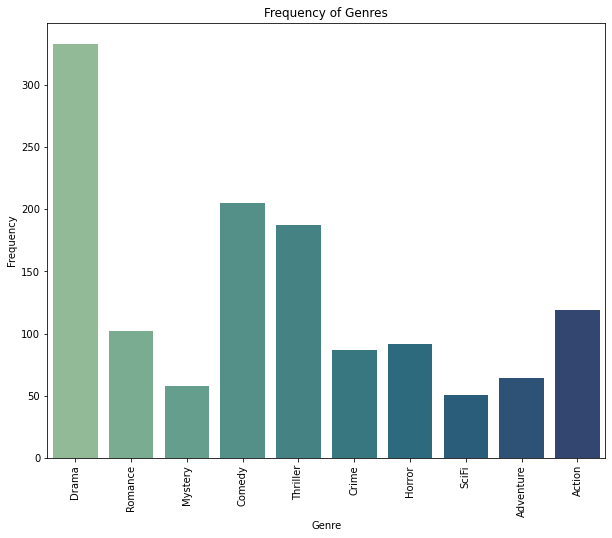

In [43]:
# Take the subset of the dataframe for only the genres included in the final dataset. 
final_genres_df = budgets_and_genre_dummys.loc [ (budgets_and_genre_dummys['Romance'] == 1) 
                                                | (budgets_and_genre_dummys['Adventure'] == 1) 
                                                | (budgets_and_genre_dummys['Drama'] == 1) 
                                                | (budgets_and_genre_dummys['Horror'] == 1) 
                                                | (budgets_and_genre_dummys['Action'] == 1) 
                                                | (budgets_and_genre_dummys['Comedy'] == 1) 
                                                | (budgets_and_genre_dummys['Thriller'] == 1) 
                                                | (budgets_and_genre_dummys['Crime'] == 1) 
                                                | (budgets_and_genre_dummys['SciFi'] == 1) 
                                                | (budgets_and_genre_dummys['Mystery'] == 1)  ]


# Create a frequency dictionary for the genres 
# (must be done manually rather than my value_counts since there are multiple genres in each row)

def freq_dictionary(dataframe):
    genre_sums = {}
    
    for col in dataframe.columns:
    
        ignored_cols = ["title", "genre_ids","total_profit",'relative_profit_cat',""]
        
        # for each genre column
        if col not in ignored_cols:
            
            # create a key in the dictionary for that genre
            # make the value equal to the total number of movies with a 1 in that column (equal to sum)
            genre_sums[col] = dataframe[col].sum()
        
    return genre_sums

genre_sums = freq_dictionary(final_genres_df)


# plot the frequency dictionary in order at which the genres appear in the final contingency table
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x = list(genre_sums.keys()), y = list(genre_sums.values()), order = genre_order, palette = 'crest')
plt.xticks(rotation = 90)
ax.set_title("Frequency of Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Frequency");

While there doesn't appear to be a particular trend in this order, it is interesting that dramas, which have the highest proportion of low profit movies, are also the most represented.

3. Stacked Bar Charts

The following barchart visualizes the proportional differences in profit categories for the genres in the final contingency table.

Resource: https://www.datasciencelearner.com/stacked-bar-graph-in-python-step/#:~:text=We%20can%20draw%20a%20stacked%20bar%20graphs%20in,seaborn%20library%20as%20well%20to%20achieve%20the%20same.

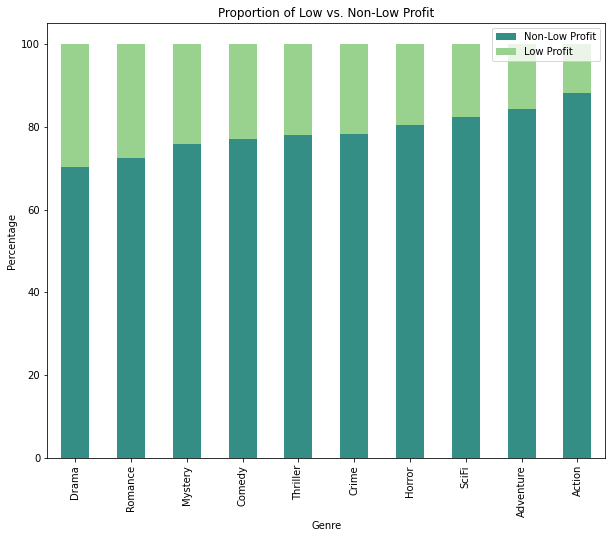

In [44]:
ax = low_v_not_contingency.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Low vs. Non-Low Profit", 
                           figsize = (10,8),
                           color = ['#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Non-Low Profit','Low Profit']);

The following bar charts visualize the proportion of high, medium, and low profit movies for all genres included in the final analysis. The only difference between the two is the order in which the genres are sorted. The former sorts from largest to smallest proportion of high profit movies, the latter sorts from largest to smallest proportion of low profit movies.

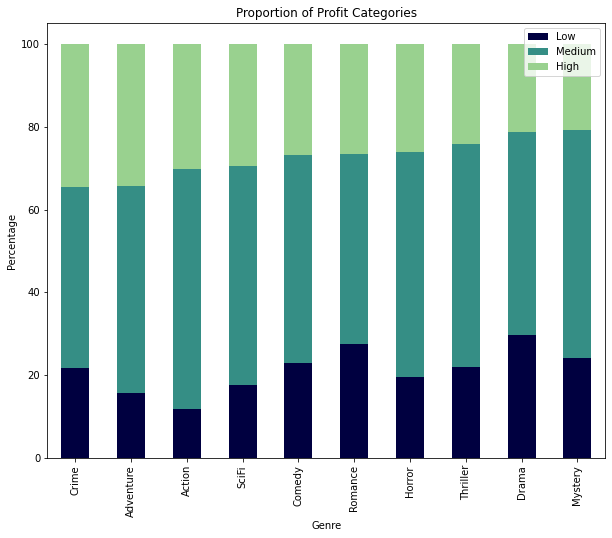

In [45]:
# Create percetange columns
contingency_table['perc_low'] = round( (contingency_table['low'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_medium'] = round( (contingency_table['medium'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_high'] = round( (contingency_table['high'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

# Create new dataframe which only contains the percentage columns
# sort by greatest proportion of hight profit movies to lowest proportion
contingency_table_prop = contingency_table[['perc_low','perc_medium','perc_high']]
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_high', ascending = False)

# plot the percentage dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

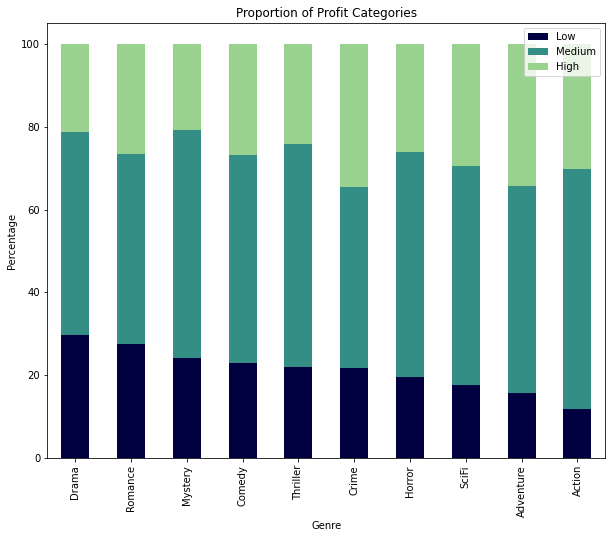

In [46]:
# re-sort proportion table from highest percentage of low profit movies to lowest proportion
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_low', ascending = False)

# plot the newly sorted dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

### Genre (Landon)

#### Datasets and cleaning

#### Analysis methods

#### Conclusion / Suggestion

#### What limitations are there?